##### Copyright 2018 The TensorFlow Hub Authors.

Licensed under the Apache License, Version 2.0 (the "License");

In [ ]:
# Copyright 2018 The TensorFlow Hub Authors. All Rights Reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.
# ==============================================================================

# Object Detection
## Bounding Boxes & Initial Labels Creation


<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://www.tensorflow.org/hub/tutorials/object_detection"><img src="https://www.tensorflow.org/images/tf_logo_32px.png" />View on TensorFlow.org</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/colab_logo_32px.png" />Run in Google Colab</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/hub/blob/master/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png" />View source on GitHub</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/hub/examples/colab/object_detection.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png" />Download notebook</a>
  </td>
</table>

This Colab demonstrates use of a TF-Hub module trained to perform object detection. We will use the two models here to scan through food images and draw initial bounding boxes (with labels), and confirm later in our simple image annotation tool.

## Setup


In [ ]:
#@title Imports and function definitions

# For running inference on the TF-Hub module.
import tensorflow as tf

import tensorflow_hub as hub

# For downloading the image.
import matplotlib.pyplot as plt
import tempfile
from six.moves.urllib.request import urlopen
from six import BytesIO

# For drawing onto the image.
import numpy as np
from PIL import Image
from PIL import ImageColor
from PIL import ImageDraw
from PIL import ImageFont
from PIL import ImageOps

# For measuring the inference time.
import time

from pathlib import Path
import pandas as pd

# Print Tensorflow version
print(tf.__version__)

# Check available GPU devices.
print("The following GPU devices are available: %s" % tf.test.gpu_device_name())

Let's get the [food image dataset](https://www.kaggle.com/kmader/food41) from Kaggle. Example notebook about how to retrieve Kaggle data on Colab could be found [here](https://colab.research.google.com/drive/1DofKEdQYaXmDWBzuResXWWvxhLgDeVyl).

In [ ]:
# Run this cell and select the kaggle.json file downloaded
# from the Kaggle account settings page.
from google.colab import files
files.upload()

In [ ]:
# Let's make sure the kaggle.json file is present.
!ls -lha kaggle.json

In [ ]:
# Next, install the Kaggle API client.
!pip install -q kaggle

In [ ]:
# The Kaggle API client expects this file to be in ~/.kaggle,
# so move it there.
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

# This permissions change avoids a warning on Kaggle tool startup.
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
# List available datasets.
!kaggle datasets list

In [ ]:
# Copy the stackoverflow data set locally.
!kaggle datasets download -d kmader/food41

This notebook is only for demo purpose - so I didn't unzip the whole food data but a fraction of it.

In [ ]:
!unzip food41.zip 'images/*' -d /content/ # stop in the middle if you are not intended to inflate all files

In [10]:
# need meta info
!unzip food41.zip 'meta/*' -d /content/

Archive:  food41.zip
  inflating: /content/meta/meta/classes.txt  
  inflating: /content/meta/meta/labels.txt  
  inflating: /content/meta/meta/test.json  
  inflating: /content/meta/meta/test.txt  
  inflating: /content/meta/meta/train.json  
  inflating: /content/meta/meta/train.txt  


Get the dataset together :)

In [11]:
def read_txt_return_list(filepath):
  with open(filepath, 'r') as f:
    lines = f.read().split('\n')
  return lines

In [12]:
classes_list = read_txt_return_list('/content/meta/meta/classes.txt')
label_list = read_txt_return_list('/content/meta/meta/labels.txt')

In [13]:
# confirm the 1 to 1 matching relationship
print(len(classes_list), len(label_list))
print(classes_list[10], label_list[10])

102 102
bruschetta Bruschetta


In [14]:
# source: https://www.kaggle.com/nanigans/deep-clustering
class FoodDataset():
    def __init__(self, root, transforms=None, labels=[], classes_list=[], limit=None):
        self.root = Path(root)
        self.image_paths = list(Path(root).glob('*/*.jpg'))
        if limit:
            self.image_paths = self.image_paths[:limit]
        self.labels = labels
        self.classes_list = classes_list
        self.transforms = transforms
        #self.classes = set([path.parts[-2] for path in self.image_paths])
        
    def __getitem__(self, index):
        image_path = self.image_paths[index]
        this_image_class = image_path.parts[-2]
        label = self.labels[self.classes_list.index(this_image_class)] if self.labels else 0
        image = Image.open(image_path)
        if self.transforms:
            return self.transforms(image), label
        return image, label

    def get_path_label(self, index):
        image_path = self.image_paths[index]
        this_image_class = image_path.parts[-2]
        label = self.labels[self.classes_list.index(this_image_class)] if self.labels else 0
        return str(image_path), label
            
    def __len__(self):
        return len(self.image_paths)    

In [16]:
# data
root = '/content/images'
limit_images = 5000

In [ ]:
dataset = FoodDataset(root=root, limit=limit_images, labels=label_list, classes_list=classes_list)

In [18]:
len(dataset)

5000

Caprese salad


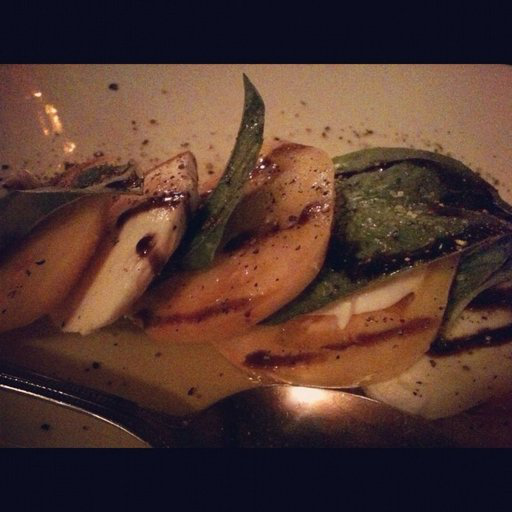

In [19]:
image, label = dataset[2089]
print(label)
image

## Example use

### Helper functions for downloading images and for visualization.

Visualization code adapted from [TF object detection API](https://github.com/tensorflow/models/blob/master/research/object_detection/utils/visualization_utils.py) for the simplest required functionality.

In [ ]:
def display_image(image):
  fig = plt.figure(figsize=(20, 15))
  plt.grid(False)
  plt.imshow(image)


def download_and_resize_image(url, new_width=256, new_height=256,
                              display=False):
  _, filename = tempfile.mkstemp(suffix=".jpg")
  response = urlopen(url)
  image_data = response.read()
  image_data = BytesIO(image_data)
  pil_image = Image.open(image_data)
  pil_image = ImageOps.fit(pil_image, (new_width, new_height), Image.ANTIALIAS)
  pil_image_rgb = pil_image.convert("RGB")
  pil_image_rgb.save(filename, format="JPEG", quality=90)
  print("Image downloaded to %s." % filename)
  if display:
    display_image(pil_image)
  return filename


def draw_bounding_box_on_image(image,
                               ymin,
                               xmin,
                               ymax,
                               xmax,
                               color,
                               font,
                               thickness=4,
                               display_str_list=()):
  """Adds a bounding box to an image."""
  draw = ImageDraw.Draw(image)
  im_width, im_height = image.size
  (left, right, top, bottom) = (xmin * im_width, xmax * im_width,
                                ymin * im_height, ymax * im_height)
  draw.line([(left, top), (left, bottom), (right, bottom), (right, top),
             (left, top)],
            width=thickness,
            fill=color)

  # If the total height of the display strings added to the top of the bounding
  # box exceeds the top of the image, stack the strings below the bounding box
  # instead of above.
  display_str_heights = [font.getsize(ds)[1] for ds in display_str_list]
  # Each display_str has a top and bottom margin of 0.05x.
  total_display_str_height = (1 + 2 * 0.05) * sum(display_str_heights)

  if top > total_display_str_height:
    text_bottom = top
  else:
    text_bottom = top + total_display_str_height
  # Reverse list and print from bottom to top.
  for display_str in display_str_list[::-1]:
    text_width, text_height = font.getsize(display_str)
    margin = np.ceil(0.05 * text_height)
    draw.rectangle([(left, text_bottom - text_height - 2 * margin),
                    (left + text_width, text_bottom)],
                   fill=color)
    draw.text((left + margin, text_bottom - text_height - margin),
              display_str,
              fill="black",
              font=font)
    text_bottom -= text_height - 2 * margin


def draw_boxes(image, boxes, class_names, scores, max_boxes=10, min_score=0.1):
  """Overlay labeled boxes on an image with formatted scores and label names."""
  colors = list(ImageColor.colormap.values())

  try:
    font = ImageFont.truetype("/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Regular.ttf",
                              25)
  except IOError:
    print("Font not found, using default font.")
    font = ImageFont.load_default()

  for i in range(min(boxes.shape[0], max_boxes)):
    if scores[i] >= min_score:
      ymin, xmin, ymax, xmax = tuple(boxes[i])
      display_str = "{}: {}%".format(class_names[i].decode("ascii"),
                                     int(100 * scores[i]))
      color = colors[hash(class_names[i]) % len(colors)]
      image_pil = Image.fromarray(np.uint8(image)).convert("RGB")
      draw_bounding_box_on_image(
          image_pil,
          ymin,
          xmin,
          ymax,
          xmax,
          color,
          font,
          display_str_list=[display_str])
      np.copyto(image, np.array(image_pil))
  return image

## Apply module

Pick an object detection module and apply on the downloaded image. Modules:
* **FasterRCNN+InceptionResNet V2**: high accuracy,
* **ssd+mobilenet V2**: small and fast.

In [ ]:
module_handle = "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1" #@param ["https://tfhub.dev/google/openimages_v4/ssd/mobilenet_v2/1", "https://tfhub.dev/google/faster_rcnn/openimages_v4/inception_resnet_v2/1"]

detector = hub.load(module_handle).signatures['default']

In [ ]:
def load_img(path):
  img = tf.io.read_file(path)
  img = tf.image.decode_jpeg(img, channels=3)
  return img

In [ ]:
def run_detector(detector, path, topn=None, display_ind=True):
  img = load_img(path)

  converted_img  = tf.image.convert_image_dtype(img, tf.float32)[tf.newaxis, ...]
  start_time = time.time()
  result = detector(converted_img)
  end_time = time.time()

  result = {key:value.numpy() for key,value in result.items()}
  image_size = Image.fromarray(np.uint8(image)).convert("RGB").size
  
  print("Found %d objects." % len(result["detection_scores"]))
  print("Inference time: ", end_time-start_time)

  if topn is not None:
    if topn > len(result["detection_scores"]):
      result['image_size'] = image_size
      if display_ind:
        image_with_boxes = draw_boxes(
            img.numpy(), result["detection_boxes"],
            result["detection_class_entities"], result["detection_scores"]) 
        display_image(image_with_boxes)
      
      return result
    else:
      print("Trimming for the top %d results only." % topn)
      new_res = {}
      for key in result:
        new_res[key] = result[key][:topn]

      for i in range(1,topn+1):
        print('Top {} class: {}, confidence: {}'.format(i, new_res["detection_class_entities"][i-1], new_res["detection_scores"][i-1]))

      new_res['image_size'] = image_size
      if display_ind:
        image_with_boxes = draw_boxes(
            img.numpy(), new_res["detection_boxes"],
            new_res["detection_class_entities"], new_res["detection_scores"]) 
        display_image(image_with_boxes)

      return new_res

In [72]:
ground_truth_labels = {}

In [73]:
image_path, label = dataset.get_path_label(888)
ground_truth_labels[image_path] = label
print(label)

Beef carpaccio


In [ ]:
result = run_detector(detector, image_path, topn=4)

In [75]:
# check result
result

{'detection_boxes': array([[0.01177272, 0.04451187, 0.93582666, 0.99134016],
        [0.02029943, 0.01230174, 0.9762262 , 0.92673635],
        [0.6183152 , 0.42867616, 0.8540082 , 0.7227862 ],
        [0.7094268 , 0.6110466 , 0.8554892 , 0.73901373]], dtype=float32),
 'detection_class_entities': array([b'Salad', b'Pizza', b'Vegetable', b'Vegetable'], dtype=object),
 'detection_class_labels': array([531, 347, 504, 504]),
 'detection_class_names': array([b'/m/0grw1', b'/m/0663v', b'/m/0f4s2w', b'/m/0f4s2w'], dtype=object),
 'detection_scores': array([0.58702034, 0.48584148, 0.17262506, 0.1329013 ], dtype=float32),
 'image_size': (512, 383)}

Note that the bounding box coordinates are `ymin, xmin, ymax, xmax`, whereas the simple annotator has `xmin, xmax, ymin, ymax` instead. Also, the coordinates are relative to the image size - will need to convert it back to the original corrdinates, too. Will need to format this into a file that could be consumed by the labeling tool.

In [76]:
format_list = []

In [77]:
for i in range(4):
  format_list.append([image_path, i+1, 
                      result['detection_class_entities'][i].decode("utf-8") , 
                      result['detection_boxes'][i][1] * result['image_size'][0], 
                      result['detection_boxes'][i][3] * result['image_size'][0], 
                      result['detection_boxes'][i][0] * result['image_size'][1], 
                      result['detection_boxes'][i][2] * result['image_size'][1]])

In [78]:
df = pd.DataFrame(format_list, columns=['image', 'id', 'name', 'xMin', 'xMax', 'yMin', 'yMax'])
df

,image,id,name,xMin,xMax,yMin,yMax
0,/content/images/beef_carpaccio/2098481.jpg,1,Salad,22.790079,507.566162,4.508950,358.421610
1,/content/images/beef_carpaccio/2098481.jpg,2,Pizza,6.298490,474.489014,7.774681,373.894639
2,/content/images/beef_carpaccio/2098481.jpg,3,Vegetable,219.482193,370.066528,236.814729,327.085140
3,/content/images/beef_carpaccio/2098481.jpg,4,Vegetable,312.855865,378.375031,271.710472,327.652361


### More images
Perform inference on some additional images with time tracking.


In [ ]:
topn = 5
df_list = []

In [80]:
def convert_output_to_df(result, image_path):
  temp_list = []
  num_of_records = len(result['detection_class_entities'])

  for i in range(num_of_records):
    temp_list.append([image_path, i+1, 
                        result['detection_class_entities'][i].decode("utf-8") , 
                        result['detection_boxes'][i][1] * result['image_size'][0], 
                        result['detection_boxes'][i][3] * result['image_size'][0], 
                        result['detection_boxes'][i][0] * result['image_size'][1], 
                        result['detection_boxes'][i][2] * result['image_size'][1]])
    
  df = pd.DataFrame(temp_list, columns=['image', 'id', 'name', 'xMin', 'xMax', 'yMin', 'yMax'])
  return df

In [ ]:
image_path, label = dataset.get_path_label(37)
print("Ground truth label: {}\n".format(label))
result = run_detector(detector, image_path, topn=topn)
ground_truth_labels[image_path] = label
df_list.append(convert_output_to_df(result, image_path))

In [ ]:
image_path, label = dataset.get_path_label(1001)
ground_truth_labels[image_path] = label
print("Ground truth label: {}\n".format(label))
result = run_detector(detector, image_path, topn=topn)
df_list.append(convert_output_to_df(result, image_path))

In [ ]:
image_path, label = dataset.get_path_label(1984)
ground_truth_labels[image_path] = label
print("Ground truth label: {}\n".format(label))
result = run_detector(detector, image_path, topn=topn)
df_list.append(convert_output_to_df(result, image_path))

In [84]:
for small_df in df_list:
  df = df.append(small_df, ignore_index=True)
  print(len(df))

9
14
19


In [85]:
df.head()

,image,id,name,xMin,xMax,yMin,yMax
0,/content/images/beef_carpaccio/2098481.jpg,1,Salad,22.790079,507.566162,4.508950,358.421610
1,/content/images/beef_carpaccio/2098481.jpg,2,Pizza,6.298490,474.489014,7.774681,373.894639
2,/content/images/beef_carpaccio/2098481.jpg,3,Vegetable,219.482193,370.066528,236.814729,327.085140
3,/content/images/beef_carpaccio/2098481.jpg,4,Vegetable,312.855865,378.375031,271.710472,327.652361
4,/content/images/beef_carpaccio/3192322.jpg,1,Food,15.354609,498.599701,34.969496,352.315513


In [86]:
ground_truth_labels

{'/content/images/beef_carpaccio/2098481.jpg': 'Beef carpaccio',
 '/content/images/beef_carpaccio/3192322.jpg': 'Beef carpaccio',
 '/content/images/bread_pudding/283656.jpg': 'Bread pudding',
 '/content/images/bread_pudding/518810.jpg': 'Bread pudding'}

I have some code here to change file paths. Skip if not needed.

In [89]:
df['image_new'] = df['image'].apply(lambda x: x.split('/')[-2] + '_' + x.split('/')[-1])
df['image_new'].head()

0    beef_carpaccio_2098481.jpg
1    beef_carpaccio_2098481.jpg
2    beef_carpaccio_2098481.jpg
3    beef_carpaccio_2098481.jpg
4    beef_carpaccio_3192322.jpg
Name: image_new, dtype: object

In [92]:
df.rename(columns={"image": "old_img_path", "image_new": "image"}, inplace=True)

In [93]:
df.head()

,old_img_path,id,name,xMin,xMax,yMin,yMax,image
0,/content/images/beef_carpaccio/2098481.jpg,1,Salad,22.790079,507.566162,4.508950,358.421610,beef_carpaccio_2098481.jpg
1,/content/images/beef_carpaccio/2098481.jpg,2,Pizza,6.298490,474.489014,7.774681,373.894639,beef_carpaccio_2098481.jpg
2,/content/images/beef_carpaccio/2098481.jpg,3,Vegetable,219.482193,370.066528,236.814729,327.085140,beef_carpaccio_2098481.jpg
3,/content/images/beef_carpaccio/2098481.jpg,4,Vegetable,312.855865,378.375031,271.710472,327.652361,beef_carpaccio_2098481.jpg
4,/content/images/beef_carpaccio/3192322.jpg,1,Food,15.354609,498.599701,34.969496,352.315513,beef_carpaccio_3192322.jpg


In [94]:
ground_truth_labels2 = {}

for key, val in ground_truth_labels.items():
  key_abbr = key.split('/')[-2] + '_' + key.split('/')[-1]
  ground_truth_labels2[key_abbr] = val

In [95]:
ground_truth_labels2

{'beef_carpaccio_2098481.jpg': 'Beef carpaccio',
 'beef_carpaccio_3192322.jpg': 'Beef carpaccio',
 'bread_pudding_283656.jpg': 'Bread pudding',
 'bread_pudding_518810.jpg': 'Bread pudding'}

Save outputs

In [96]:
df.to_csv('faster_rcnn_tf_outputs.csv',index=False)

In [97]:
import csv

with open('food_samples_ground_truth_labels.csv', 'w') as f:
    for key, item in ground_truth_labels2.items():
        f.write("%s,%s\n"%(key,item))

Now the fun part begins - we will visualize the bounding boxes and change their labels in the simple annotation tool. Stay tuned!